# Prepare label sets 




For integrating FTW and Lacuna+/Mapping Africa labels. The main work is to reshape Lacuna+ labels to be the same dimensions as FTW labels, and then to design a common catalog for both. 

There are two main factors to be considered when integrating the labels sets:

1. FTW labels are 256 X 256 (a brief inspection in QGIS suggested that some are not exactly square) and have two time points.  
2. Lacuna labels are 224 x 224 and have a single time point. 

The easiest thing to do is to resample the Lacuna Labels to 256 X 256, which will help  prevent loss of spatial context in the FTW labels. 

Another aspect is band order. FTW bands are RGB-NIR, while Lacuna+ are BGR-NIR. The latter should be reshaped to FTW band order. 

We will also want to add a time point to the FTW labels when we get further down the track.  

In [1]:
import os
import re
from pathlib import Path

import geopandas as gpd
import geodatasets
import rioxarray as rxr
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

import ftw
from makelabels import MakeLabels
# from instancemaker import MakeInstances

from torchgeo.datasets import RasterDataset, VectorDataset
from torchgeo.samplers import GridGeoSampler
# import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

Paths

In [2]:
project_dir = os.path.dirname(os.getcwd())
data_dir = "/Users/LEstes/data/labels/cropland/"

## Resize Lacuna Labels

For ease of cross-use, we will resize the Lacuna labels to 256 x 256, using the existing functions from `lacunalabels`. 

### Catalog

Use our existing catalog, updating some of the values in them, for working with Lacuna+ labels.   

In [3]:
catalog = pd.read_csv(Path(project_dir) / "data/croplands3-2.1.1.csv")
catalog["date"] = catalog.apply(
    lambda x: 
    f"{re.sub(".tif", "", os.path.basename(x["image"]).split("_")[1])}-15", 
    axis=1
)
catalog.rename(columns={"image": "images", "label": "labels"}, inplace=True)
catalog.drop(columns="assignment_id", inplace=True)
catalog.head(n=3)

,name,Class,dataset,rscore,rscore2,Rscore,x,y,farea,fprop,cntry,year,label_group,usage,labels,images,date
0,NG0239934,2,v2.0.0,NaN,NaN,0.811741,6.4365,12.7425,0.449518,0.392837,NG,2022,3,train,3cl/v2-0-0/labels/NG0239934_122_2022-03.tif,3cl/v2-0-0/images/NG0239934_2022-03.tif,2022-03-15
1,NG0781094,2,v2.0.0,NaN,NaN,0.811741,4.7015,11.4925,0.466465,0.195412,NG,2017,3,train,3cl/v2-0-0/labels/NG0781094_175_2017-02.tif,3cl/v2-0-0/images/NG0781094_2017-02.tif,2017-02-15
2,ET0678794,2,v2.0.0,NaN,NaN,0.811741,36.9315,11.4825,0.230887,0.045958,ET,2020,3,train,3cl/v2-0-0/labels/ET0678794_177_2020-02.tif,3cl/v2-0-0/images/ET0678794_2020-02.tif,2020-02-15


Need to get centroids for NGS labels

In [ ]:
ngs_dfin = catalog.query("name.str.startswith('NGS')")
ngs_dfout = []
for i, row in ngs_dfin.iterrows():
    img = rxr.open_rasterio(Path(data_dir) / row["images"])
    row["x"] = img.x.values.mean()
    row["y"] = img.y.values.mean()
    ngs_dfout.append(row)

ngs_dfout = pd.DataFrame(ngs_dfout)
ngs_dfout.head(n=3)

    # print(img.rio.center)

Update catalog

In [ ]:
# ngs_dfin
catalog = pd.concat([catalog.query("~name.str.startswith('NGS')"), 
                     ngs_dfout]).sort_values(by="name")
catalog.reset_index(drop=True, inplace=True)
catalog.head(n=3)

### Resize image chips

Going to try using the `MakeLabels` (from `lacunalabels`) class and some of its built in functions to do this. 

Set up output directories

In [4]:
# image_dir = Path(data_dir)) / \
#     "data/imagery/planet/tiles" # input directory
chip_dir = Path(data_dir) / "mappingafrica-256/imagery" 
label_dir = Path(data_dir) / "mappingafrica-256/labels"  # output
log_dir = Path(project_dir) / "logs"
# log_file = str(Path(root_dir) / "logs/image-chipping")

for d in [chip_dir, label_dir, log_dir]:
    if not os.path.isdir(d):
        os.makedirs(d)
        # print(f"{d} is Not a dir")

Set up `MakeLabels` class


In [ ]:
log_file = str(Path(project_dir) / "logs/image-resizing")
mkl = MakeLabels(logfile=log_file)

# row = catalog.iloc[34402]
# mkl.image_chipper(catrow=row,
#                   src_dir=data_dir, 
#                   dst_dir=chip_dir, 
#                   src_col="images", 
#                   date_col="date",
#                   w=0.0025,
#                   rows=256, 
#                   cols=256,
#                   crs="EPSG:4326")

Set up arguments and run resizing to 256x256 on image chips. 

In [ ]:
%%time
kwargs = {
    "src_dir": data_dir, 
    "dst_dir": chip_dir, 
    "src_col": "images",
    "date_col": "date",
    "w": 0.0025, 
    "rows": 256,
    "cols": 256, 
    "crs": "epsg:4326",
    "verbose": False,
    "overwrite": False
 }

catalogf = mkl.run_parallel_threads(
    catalog=catalog, #,.iloc[0:20], 
    function=mkl.image_chipper,
    args=kwargs,
    nworkers=4
)

catalogf = pd.DataFrame(catalogf)

### Resize 3-class labels

Rather than reassemble all the original vectors from the extra, non-Lacuna labels (v1.3.0), let's simply vectorize the 3-class labels, then create new 256x256 labels. 

#### Vectorize v1.3.0 labels

Because it is hard to trace all the original vectors for v1.3.0, we will just vectorize the label chips.  

This required some extra functions to help with vectorizing, and then using 
the `MakeInstances` class from `instancemaker`. 

In [ ]:
def any_intersections(gdf):
    for idx, geom in enumerate(gdf.geometry):
        if gdf.drop(idx).intersects(geom).any():
            return True
    return False

def buffer_without_overlap(gdf, distance):
    # Buffer all polygons
    buffered = gdf.copy()
    buffered['geometry'] = buffered.geometry.buffer(distance)
    # Remove overlaps: for each polygon, subtract all others
    result_geoms = []
    for i, geom in enumerate(buffered.geometry):
        others = buffered.drop(i).geometry.unary_union
        result_geoms.append(geom.difference(others))
    return gpd.GeoDataFrame(buffered.drop(columns='geometry'), 
                            geometry=result_geoms, crs=gdf.crs)

def buffer_no_overlap_union(gdf, distance):
    buffered = gdf.buffer(distance)
    unioned = buffered.unary_union
    # Explode multipolygons into individual polygons
    if isinstance(unioned, Polygon):
        geoms = [unioned]
    else:
        geoms = list(unioned.geoms)
    return gpd.GeoDataFrame(geometry=geoms, crs=gdf.crs)

def buffer_without_overlap(gdf, distance):
    # Buffer all polygons
    buffered = gdf.copy()
    buffered['geometry'] = buffered.geometry.buffer(distance)
    # Remove overlaps: for each polygon, subtract all others
    result_geoms = []
    for i, geom in enumerate(buffered.geometry):
        others = buffered.drop(i).geometry.unary_union
        result_geoms.append(geom.difference(others))
    return gpd.GeoDataFrame(buffered.drop(columns='geometry'), 
                            geometry=result_geoms, crs=gdf.crs)

def buffer_no_overlap_union(gdf, distance):
    buffered = gdf.buffer(distance)
    unioned = buffered.unary_union
    # Explode multipolygons into individual polygons
    if isinstance(unioned, Polygon):
        geoms = [unioned]
    else:
        geoms = list(unioned.geoms)
    return gpd.GeoDataFrame(geometry=geoms, crs=gdf.crs)

def any_true_overlaps(gdf):
    for idx, geom in enumerate(gdf.geometry):
        others = gdf.drop(idx)
        # Use .overlaps() instead of .intersects() to ignore touching
        if others.overlaps(geom).any():
            return True
    return False


In [ ]:
config = {
    "kernel": [[0, 1, 0],  # image morphology filter
        [1, 1, 1],
        [0, 1, 0]]
}
mki = MakeInstances(kernel=np.array(config["kernel"]))

Extract v1.3.0 labels with fields

In [ ]:
field_catalog = (catalog.query("fprop>0 & dataset=='v1.3.0'")
                 .reset_index(drop=True))
field_catalog.head(n=3)

Repolygonize labels. After some experimentation, and finding the rasterized labels for Zambia did not have a full edge class in many cases, it appeared best to relabel the rasterized labels interior class with a bit of erosion and dilation (1 iteration each), and then polygonize. 

In [ ]:
polys_list = []
for i, row in field_catalog.iterrows():
    if i % 1000 == 0:
        print(i)
    lbl = rxr.open_rasterio(Path(data_dir) / row["labels"])
    mask = lbl.squeeze() == 1
    lbled = mki.label_prediction(mask, 0.5, np.array(config["kernel"]), 1, 1, 0)
    lbled_da = xr.DataArray(
        lbled['labels'], 
        dims=("y", "x"),
        coords={"y": lbl.y, "x": lbl.x}
    )
    polys = mki.polygonize(lbled_da, 0.000025, False, False, None, 0)
    # polys = mki.polygonize(lbled_da, None, False, False, None, 0)
    polys_buf = buffer_no_overlap_union(polys, distance=0.00001)
    # polys_buf["geometry"] = polys_buf["geometry"].simplify(
    #     tolerance=0.00003, preserve_topology=True
    # )
    # polys = mki.polygonize(mask, 0.00003, False, False, None, 0)
    # polys_buf = buffer_no_overlap_union(polys, distance=0.000015)
    assert not any_true_overlaps(polys_buf) 
    polys_buf["name"] = row["name"]
    polys_buf["year"] = row["year"]
    polys_buf["date"] = row["date"]
    polys_list.append(polys_buf)

Write to files

In [ ]:
polys_gdf = pd.concat(polys_list)[["name", "year", "date", "geometry"]]
# polys_gdf.to_parquet(Path(project_dir) / "data/v1-3-0-fields.parquet")
polys_gdf.to_parquet(Path(project_dir) / "data/v1-3-0-fields2.parquet")
# polys_gdf.to_file(Path(project_dir) / "data/v1-3-0-fields.geojson", 
#                   driver="GeoJSON")
polys_gdf = gpd.read_parquet(Path(project_dir) / "data/v1-3-0-fields2.parquet")
polys_gdf.head(n=3)

Select random sites for plotting. By and large these re-polygonizations seem to separate into the correct number of fields with reasonably smooth boundaries. A few very close ones might join slightly, but only in a small number of cases. Counting samples, out of 30 checked at random, only 1 had a small join between two adjacent polygons. 

In [ ]:
N = 1
fld_smpl = field_catalog.sample(n=N)
# fld_smpl = field_catalog.query("name=='TZ0399937'")
# "TZ0399937"
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(7,7))
axes = ax if N > 1 else [ax]
for i, row in fld_smpl.reset_index().iterrows():
    current_ax = axes[i]
    lbl = rxr.open_rasterio(Path(data_dir) / row["labels"])
    lbl.plot(ax=current_ax, add_colorbar=False)
    fld_polys = polys_gdf[polys_gdf.name==row['name']]
    fld_polys.boundary.plot(ax=current_ax, color="red",linewidth=2)
    current_ax.axis('off')
    current_ax.set_title(f"{row["name"]} with {len(fld_polys)} fields")

In [ ]:
# any_intersections(polys_buf2)
# any_true_overlaps(polys_buf2)
# fig, ax = plt.subplots(figsize=(10,10))
# polys_buf.boundary.plot(ax=ax, color="black")
# polys_buf2.boundary.plot(ax=ax, color="red")
# polys.boundary.plot(ax=ax, color="blue")
# plt.show()

#### Combine best Lacuna fields with vectorized v1.3.0 fields

The best Lacuna labels are captured in the v2.0.0 catalog. 

Get Lacuna vectors


In [ ]:
lacuna_fields = gpd.read_parquet(
   "s3://africa-field-boundary-labels/mapped_fields_final.parquet" 
)
lacuna_fields["assignment_id"] = (lacuna_fields["assignment_id"]
                                  .astype(int)
                                  .astype(str))

Select by assignment id from vectors, using assignment ID embedded in the label names in our existing catalog. 

In [ ]:
## extract assignment ID from label names in our vectors
catalog2 = catalog.query("dataset=='v2.0.0'")
# catalog2.query("fprop==0")

catalog2["assignment_id"] = (
    catalog2["labels"]
    .apply(lambda x: os.path.basename(x).split("_")[1])
)
field_catalog2 = (catalog2.query("dataset=='v2.0.0' & fprop>0")
                  .reset_index(drop=True))
field_catalog2["assignment_id"] = field_catalog2["assignment_id"]

assignment_ids = field_catalog2["assignment_id"].to_list()


Extract fields

In [ ]:
selected_fields = lacuna_fields.query("assignment_id.isin(@assignment_ids)")
selected_fields = pd.merge(selected_fields, 
                           catalog2[["name", "assignment_id", "date"]], 
                           how="left", on=["name", "assignment_id"])
print(len(sorted(selected_fields.date.drop_duplicates())))
selected_fields.head(n=3)

Check equivalencies

In [ ]:
# len(selected_fields.assignment_id.unique()) == len(field_catalog2)
np.array_equal(sorted(selected_fields.name.unique()), 
               sorted(field_catalog2.name.unique()))

Check for duplicated names in each separate set, and across them

In [ ]:
(polys_gdf[["name", "date"]]
 .drop_duplicates()
 .groupby("name")
 .count()
 .reset_index()
 .query("date>1"))

In [ ]:
(selected_fields[["name", "date"]]
 .drop_duplicates()
 .groupby("name")
 .count()
 .reset_index()
 .query("date>1"))

There are a few shared sites across different datasets, but they are not from the same dates in all cases, so we can keep them. 

In [ ]:
# np.isin(selected_fields.name.unique(), polys_gdf.name.unique())
# np.isin(polys_gdf.name.unique(), selected_fields.name.unique())
shared_names = (polys_gdf[polys_gdf.name.isin(selected_fields.name.unique())]
                .name
                .unique())
catalog.query("name.isin(@shared_names)").sort_values("name")

To facilitate that, we will make up dummy assignment numbers for the v1.3.0 labels. Max values in v2.0.0 is 102000+, so we will start at 900000 for separation. Apply assignment IDs to catalog for v1.3.0 to account for non-field assignments. 

In [ ]:
# catalog2.assignment_id.astype(int).max()
catalog1 = catalog.query("dataset=='v1.3.0'").reset_index(drop=True)
# catalog1["name"].duplicated().any()
catalog1["assignment_id"] = catalog1.groupby("name").ngroup() + 900000
catalog1.reset_index(drop=True, inplace=True)
catalog1.head(n=3)

polys_gdf = pd.merge(polys_gdf, catalog1[["name", "assignment_id"]], how="left")


Combine the data together, starting with a catalog that has all the assignment IDs and dates. 

In [ ]:
catalog_w_assns = pd.concat([catalog1, catalog2], axis=0).reset_index(drop=True)
len(sorted(catalog_w_assns.date.drop_duplicates()))
catalog_w_assns.to_csv(Path(project_dir) / "data/croplands3-2.1.1-1.csv", 
                       index=False)

In [ ]:
polys_gdf["dataset"] = "v1.3.0"
selected_fields["dataset"] = "v2.0.0"
cols = ["name", "date", "dataset", "assignment_id", "geometry"]
all_fields = pd.concat([polys_gdf[cols], selected_fields[cols]], axis=0)
# all_fields["class"] = 1
# all_fields = pd.merge(
#     all_fields, 
#     catalog_w_assns[["name", "dataset", "assignment_id", "date"]], 
#     how="left", on=["name", "assignment_id"]
# )
# all_fields = all_fields[["name", "dataset", "date", "assignment_id", 
#                          "geometry"]]
all_fields["date"] = pd.to_datetime(all_fields["date"])
all_fields["assignment_id"] = all_fields["assignment_id"].astype(int)
all_fields.reset_index(drop=True, inplace=True)
all_fields.head(n=3)

Check the duplicated behavior

In [ ]:
len(all_fields.date.unique()), all_fields.date.unique()

In [ ]:
(all_fields[["name", "assignment_id"]]
 .drop_duplicates()
 .groupby("name")
 .count()
 .reset_index()
 .query("assignment_id>1"))

Now write out for chipping

In [ ]:
all_fields.to_parquet(
    Path(project_dir) / "data/v2-1-1-fields.parquet"
)

VectorDataset does not work, and also does not provide for 3 class semantic masks. 

In [ ]:
# rsa_lbl_path = Path(data_dir) / "ftw/south_africa/label_masks/semantic_3class"
# lbl_chips = sorted(os.listdir(rsa_lbl_path))# / "data/labels/"
# for i in lbl_chips:
#     lbl = rxr.open_rasterio(Path(rsa_lbl_path) / i)
#     print(np.unique(lbl.values, return_counts=True))

Some exploration shows that FTW uses 3 as the null background class in its model when training with presence only countries, otherwise background is 0 (though also NA for display purposes)

In [ ]:
catalog = pd.read_csv(Path(project_dir) /"data/croplands3-2.1.1-1.csv")
fields = gpd.read_parquet(
    Path(project_dir) / "data/v2-1-1-fields.parquet"
)
fields.head(n=3)

Adjust catalog a bit

In [6]:
keep = ["name", "assignment_id", "date", "dataset", "x", "y", "fprop", "cntry", 
        "usage", "images"]
catalog = catalog[keep]
catalog.rename(columns={"images": "image"}, inplace=True)
catalog["image"] = catalog["image"].apply(lambda x: os.path.basename(x))
catalog.head(n=3)
# catalog["image"].str

,name,assignment_id,date,dataset,x,y,fprop,cntry,usage,image
0,BF0742031,900000,2018-12-15,v1.3.0,-0.3185,11.1875,0.125957,BF,validate,BF0742031_2018-12.tif
1,BF0743326,900001,2018-12-15,v1.3.0,-0.3285,11.1825,0.029456,BF,train,BF0743326_2018-12.tif
2,BF0743327,900002,2018-12-15,v1.3.0,-0.3235,11.1825,0.210957,BF,train,BF0743327_2018-12.tif


In [7]:
log_file = str(Path(project_dir) / "logs/mappingafrica-label-chipping")
mkl = MakeLabels(logfile=log_file)

Started dataset creation


Arguments

In [8]:
kwargs = {
    "fields": fields,
    "label_dir": label_dir, 
    "image_dir": chip_dir, 
    "src_col": "image",
    "verbose": False,
    "overwrite": True
}

Run

In [9]:
catalogf = mkl.run_parallel_threads(
    catalog, mkl.threeclass_label, kwargs, 4
)
catalog_final = pd.DataFrame(catalogf).reset_index(drop=True)
catalog_final.head(n=5)

Completed run


,name,assignment_id,date,dataset,x,y,fprop,cntry,usage,image,label
0,BF0742031,900000,2018-12-15,v1.3.0,-0.3185,11.1875,0.125957,BF,validate,BF0742031_2018-12.tif,BF0742031_900000_2018-12.tif
1,BF0743326,900001,2018-12-15,v1.3.0,-0.3285,11.1825,0.029456,BF,train,BF0743326_2018-12.tif,BF0743326_900001_2018-12.tif
2,BF0743327,900002,2018-12-15,v1.3.0,-0.3235,11.1825,0.210957,BF,train,BF0743327_2018-12.tif,BF0743327_900002_2018-12.tif
3,BF0743329,900003,2018-12-15,v1.3.0,-0.3135,11.1825,0.310746,BF,train,BF0743329_2018-12.tif,BF0743329_900003_2018-12.tif
4,BF0776469,900004,2018-12-15,v1.3.0,-0.4485,11.0475,0.089226,BF,train,BF0776469_2018-12.tif,BF0776469_900004_2018-12.tif


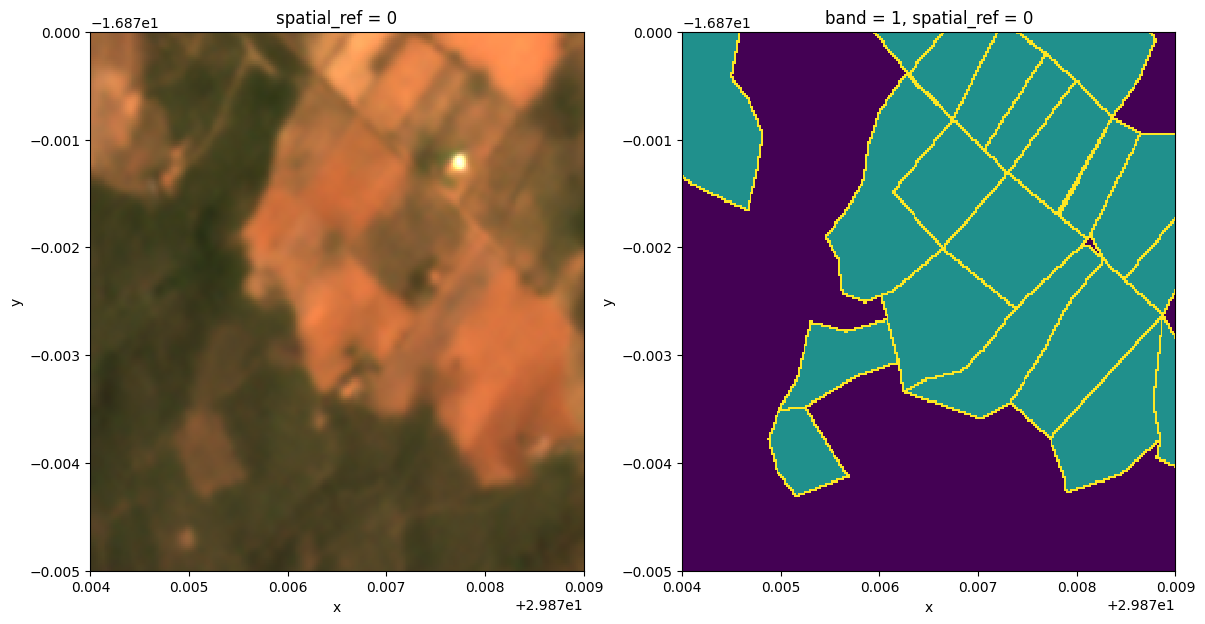

In [15]:
i = np.random.randint(0, len(catalog_final))
rw = catalog_final.iloc[i]
# lbl = threeclass_label(rw, fields, label_dir, chip_dir, "images")
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
image = rxr.open_rasterio(Path(chip_dir) / rw["image"])[[2,1,0]]
lbl = rxr.open_rasterio(Path(label_dir) / rw["label"]).squeeze()
image.plot.imshow(ax=ax[0], vmax=2000)
lbl.plot.imshow(ax=ax[1], add_colorbar=False)
plt.show()

<Axes: >

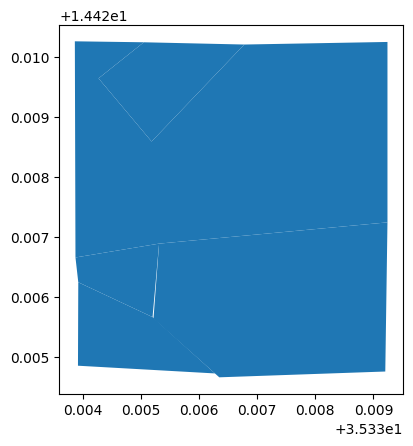

In [16]:
fields.query("name=='SD4048754'").plot()
# rw['name']

Write out catalog

In [18]:
catalog_final.to_csv(Path(project_dir) / "data/mappingafrica-3class-labels.csv", 
                     index=False)

### Re-do band order

In retrospect, we also want to re-order the bands in the Lacuna+ labels to match those in the FTW labels (which are order RGBNIR, instead of BGRNIR. 

In [ ]:
catalog = pd.read_csv(
    Path(project_dir) / "data/mappingafrica-3class-labels.csv"
)

new_dir = Path(data_dir) / "mappingafrica-256/images"
if not os.path.isdir(new_dir):
    os.makedirs(new_dir)

for idx, row in catalog.iterrows():
    src_path = Path(data_dir) / "mappingafrica-256/imagery" / row["image"]
    dst_path = new_dir / row["image"]

    if dst_path.exists():
        print(f"{str(dst_path)} exists, skipping")
        continue

    if idx % 1000 == 0:
        print(idx)

    image = rxr.open_rasterio(src_path)  # keep original DataArray
    reordered = image[[2, 1, 0, 3]]      # reorder bands

    # ensure the output has the same dtype and attrs as the source
    reordered = reordered.astype(image.dtype)
    reordered = reordered.assign_attrs(image.attrs)

    # write out (rioxarray will pick up dtype from the DataArray)
    reordered.rio.to_raster(dst_path)

## Upload resized labels to S3

To s3://africa-field-boundary-labels/ on the Registry of Open Data, using the following AWS CLI command from terminal.

```bash
DATADIR=~/data/labels/cropland/mappingafrica-256/
aws s3 sync $DATADIR s3://africa-field-boundary-labels/mappingafrica-256/ \
    -profile labels --exclude "*" --include "*.tif" --dryrun 
```

## FTW catalog

Primarily we want to create a catalog out of these that we can combine with that for the Lacuna+ labels. We can collect information on identifier and split from the geoparquets for each country. 

In [3]:
ftw_pqts = []
for dirpath, dirnames, filenames in os.walk(Path(data_dir) / "ftw"):
    for filename in filenames:
        if filename.endswith(".parquet"):
            pqt = gpd.read_parquet(f"{dirpath}/{filename}")
            pqt["country"] = os.path.basename(dirpath)
            ftw_pqts.append(pqt[["aoi_id", "country", "split"]])


Add partial paths to images/masks, and some renaming 

In [4]:
base_dir = "ftw"
ftw_cat = (pd.concat(ftw_pqts, axis=0)
           .rename(columns={"aoi_id": "name"}))
ftw_cat["window_a"] = ftw_cat.apply(
    lambda x: f"{base_dir}/{x.country}/s2_images/window_a/{x['name']}.tif", 
    axis=1
)
ftw_cat["window_b"] = ftw_cat.apply(
    lambda x: f"{base_dir}/{x.country}/s2_images/window_b/{x['name']}.tif", 
    axis=1
)
ftw_cat["mask"] = ftw_cat.apply(
    lambda x: f"{base_dir}/{x.country}/label_masks/semantic_3class/"\
        f"{x['name']}.tif", 
    axis=1
)
ftw_cat.reset_index(drop=True, inplace=True)
ftw_cat.head(n=3)

,name,country,split,window_a,window_b,mask
0,g0_0000000000-0000008192,kenya,train,ftw/kenya/s2_images/window_a/g0_0000000000-000...,ftw/kenya/s2_images/window_b/g0_0000000000-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...
1,g0_0000000512-0000009728,kenya,train,ftw/kenya/s2_images/window_a/g0_0000000512-000...,ftw/kenya/s2_images/window_b/g0_0000000512-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...
2,g0_0000000512-0000010752,kenya,train,ftw/kenya/s2_images/window_a/g0_0000000512-000...,ftw/kenya/s2_images/window_b/g0_0000000512-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...


And let's pick up information on proportion of label covered by fields, as well as those that are presence only.   

### Calculate proportional coverages

Including proportions covered by null values (for presence only labels).

In [ ]:
def count_labels(row):
    mask_path = Path(data_dir) / row["mask"]
    if not mask_path.exists():
        return None
    img = rxr.open_rasterio(mask_path)
    x, y = img.x.values.mean(), img.y.values.mean()
    unique, counts = np.unique(img[0], return_counts=True)
    count_dict = dict(zip(unique.tolist(), counts.tolist()))
    counts_full = [int(count_dict.get(cls, 0)) for cls in [0, 1, 2, 3]]
    counts_arr = np.array(counts_full, dtype=float)
    total = counts_arr.sum()
    if total == 0:
        fld_prop = null_prop = nonfld_prop = 0.0
    else:
        fld_prop = (counts_arr[1] + counts_arr[2]) / total
        null_prop = counts_arr[3] / total
        nonfld_prop = counts_arr[0] / total

    row_df = row.to_frame().T.reset_index(drop=True)
    df = pd.DataFrame(
        [[x, y] + counts_full + [fld_prop, null_prop, nonfld_prop]],
        columns=["x", "y", "C0", "C1", "C2", "C3", "fld_prop", "null_prop", 
                 "nonfld_prop"]
    )
    combined = pd.concat([row_df, df], axis=1)
    return combined

lbl_class_counts = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(count_labels, row): idx 
               for idx, row in ftw_cat.iterrows()}
    for future in as_completed(futures):
        idx = futures[future]
        try:
            res = future.result()
            if res is not None:
                lbl_class_counts.append(res)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

lbl_class_counts_df = pd.concat(lbl_class_counts, ignore_index=True)


Assign dataset identifier and version numbers and save out

In [ ]:
lbl_class_counts_df["dataset"] = "ftw"
lbl_class_counts_df["version"] = "1.0.0"
lbl_class_counts_df.to_csv(
    Path(project_dir) / "data/ftw-label-class-counts.csv", 
    index=False
)
lbl_class_counts_df.head()

In [ ]:
# check--equivalent
# smpl = lbl_class_counts_df.sample(1)
# print(smpl[["C0", "C1", "C2", "C3", "fld_prop", "null_prop", "nonfld_prop"]])

# img = rxr.open_rasterio(Path(data_dir) / "ftw" / smpl.iloc[0]["mask"])
# unique, counts = np.unique(img[0], return_counts=True)
# count_dict = dict(zip(unique.tolist(), counts.tolist()))
# counts_full = [int(count_dict.get(cls, 0)) for cls in [0,1,2,3]]
# counts_arr = np.array(counts_full)
# fld_prop = counts_arr[[1, 2]].sum() / counts.sum() 
# null_prop = counts_arr[[3]].sum() / counts.sum() 
# nonfld_prop = counts_arr[[0]].sum() / counts.sum() 
# pd.DataFrame([counts_full + [fld_prop, null_prop, nonfld_prop]], 
#              columns = ["C0", "C1", "C2", "C3", "fld_prop", "null_prop", 
#                         "nonfld_prop"])

## Combine FTW and Lacuna+ catalogs

In [8]:
base_dir = "mappingafrica-256"
lacuna_plus = pd.read_csv(
    Path(project_dir) / "data/mappingafrica-3class-labels.csv"
)
lacuna_plus.rename(
    columns={"label": "mask", "image": "window_b", "usage": "split", 
             "cntry": "country"}, 
    inplace=True
)
lacuna_plus["window_b"] = lacuna_plus.apply(
    lambda x: f"{base_dir}/images/{x['window_b']}", 
    axis=1
)
lacuna_plus["mask"] = lacuna_plus.apply(
    lambda x: f"{base_dir}/labels/{x['mask']}", 
    axis=1
)
lacuna_plus.rename(columns={"dataset": "version", "fprop": "fld_prop"}, 
                   inplace=True)
lacuna_plus["dataset"] = "mappingafrica" 
lacuna_plus["window_a"] = ""

lacuna_plus["null_prop"] = 0
lacuna_plus["nonfld_prop"] = lacuna_plus["fld_prop"].apply(lambda x: 1 - x)

lacuna_plus.head(n=3)

,name,assignment_id,date,version,x,y,fld_prop,country,split,window_b,mask,dataset,window_a,null_prop,nonfld_prop
0,BF0742031,900000,2018-12-15,v1.3.0,-0.3185,11.1875,0.125957,BF,validate,mappingafrica-256/images/BF0742031_2018-12.tif,mappingafrica-256/labels/BF0742031_900000_2018...,mappingafrica,,0,0.874043
1,BF0743326,900001,2018-12-15,v1.3.0,-0.3285,11.1825,0.029456,BF,train,mappingafrica-256/images/BF0743326_2018-12.tif,mappingafrica-256/labels/BF0743326_900001_2018...,mappingafrica,,0,0.970544
2,BF0743327,900002,2018-12-15,v1.3.0,-0.3235,11.1825,0.210957,BF,train,mappingafrica-256/images/BF0743327_2018-12.tif,mappingafrica-256/labels/BF0743327_900002_2018...,mappingafrica,,0,0.789043


In [9]:
lbl_class_counts_df = pd.read_csv(
    Path(project_dir) / "data/ftw-label-class-counts.csv" 
)

columns = ["name", "dataset", "version", "country", "x", "y", "fld_prop", 
           "nonfld_prop", "null_prop", "window_a", "window_b", "mask", "split"]
combined_catalog = (
    pd.concat([lbl_class_counts_df[columns], lacuna_plus[columns]], axis=0)
    .reset_index(drop=True)
)
combined_catalog["split"] = combined_catalog["split"].replace({
    "val": "validate"
})
combined_catalog.to_csv(
    Path(project_dir) / "data/ftw-mappingafrica-combined-catalog.csv", 
    index=False
)
combined_catalog

,name,dataset,version,country,x,y,fld_prop,nonfld_prop,null_prop,window_a,window_b,mask,split
0,g0_0000002048-0000010240,ftw,1.0.0,kenya,34.573119,0.600720,0.000519,0.000000,0.999481,ftw/kenya/s2_images/window_a/g0_0000002048-000...,ftw/kenya/s2_images/window_b/g0_0000002048-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...,test
1,g0_0000001024-0000010752,ftw,1.0.0,kenya,34.586902,0.628378,0.000061,0.000000,0.999939,ftw/kenya/s2_images/window_a/g0_0000001024-000...,ftw/kenya/s2_images/window_b/g0_0000001024-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...,train
2,g0_0000001024-0000010240,ftw,1.0.0,kenya,34.573119,0.628378,0.001083,0.000000,0.998917,ftw/kenya/s2_images/window_a/g0_0000001024-000...,ftw/kenya/s2_images/window_b/g0_0000001024-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...,train
3,g0_0000003072-0000008704,ftw,1.0.0,kenya,34.531677,0.573153,0.001129,0.000000,0.998871,ftw/kenya/s2_images/window_a/g0_0000003072-000...,ftw/kenya/s2_images/window_b/g0_0000003072-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...,train
4,g0_0000001024-0000009728,ftw,1.0.0,kenya,34.559290,0.628378,0.000916,0.000000,0.999084,ftw/kenya/s2_images/window_a/g0_0000001024-000...,ftw/kenya/s2_images/window_b/g0_0000001024-000...,ftw/kenya/label_masks/semantic_3class/g0_00000...,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109555,ZW1290563,mappingafrica,v2.0.0,ZW,29.661500,-21.757500,0.424884,0.575116,0.000000,,mappingafrica-256/images/ZW1290563_2022-06.tif,mappingafrica-256/labels/ZW1290563_16779_2022-...,train
109556,ZW1323816,mappingafrica,v2.0.0,ZW,29.646500,-22.052500,0.000000,1.000000,0.000000,,mappingafrica-256/images/ZW1323816_2022-06.tif,mappingafrica-256/labels/ZW1323816_8232_2022-0...,train
109557,ZW1327144,mappingafrica,v2.0.0,ZW,31.086500,-22.082500,0.631059,0.368941,0.000000,,mappingafrica-256/images/ZW1327144_2022-06.tif,mappingafrica-256/labels/ZW1327144_100281_2022...,train
109558,ZW1330078,mappingafrica,v2.0.0,ZW,31.426500,-22.112500,0.733777,0.266223,0.000000,,mappingafrica-256/images/ZW1330078_2018-08.tif,mappingafrica-256/labels/ZW1330078_100282_2018...,train


### Plots

In [13]:
gdf_pts = gpd.GeoDataFrame(
    combined_catalog,
    geometry=gpd.points_from_xy(combined_catalog.x, combined_catalog.y),
    crs="EPSG:4326",
)
# gdf_pts = gdf_pts.query("country=='portugal'")
# gdf_pts = gdf_pts.query("x>-35 & x<-23")

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/"\
        "ne_110m_admin_0_countries.zip"
)

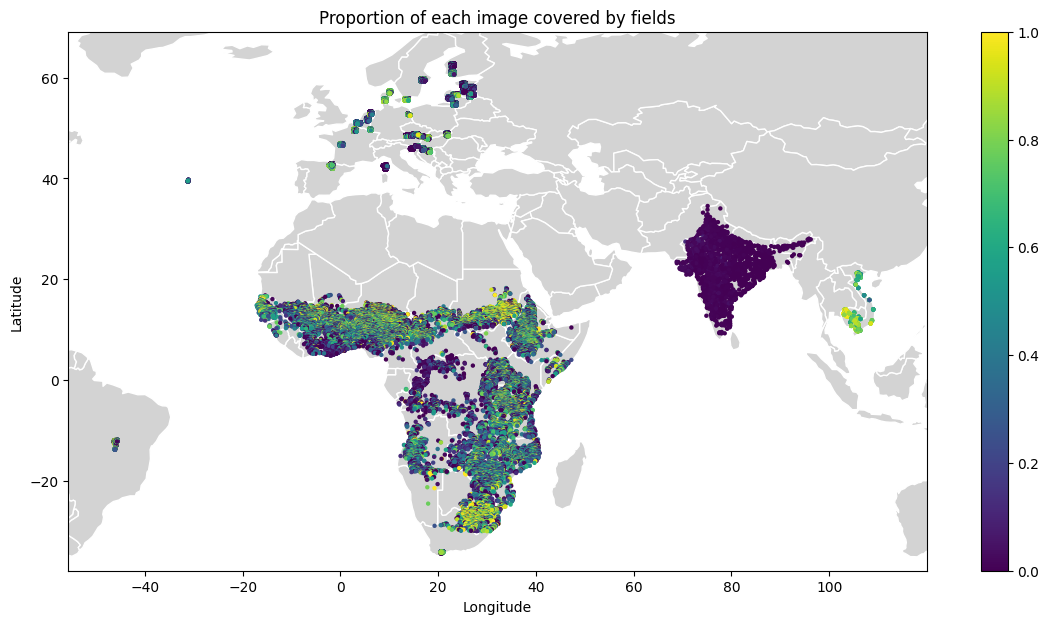

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
world.plot(ax=ax, color="lightgray", edgecolor="white")
gdf_pts.plot(column="fld_prop", cmap="viridis", legend=True, markersize=10, 
             ax=ax, s=8, linewidths=0)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Proportion of each image covered by fields")
ax.set_xlim(gdf_pts.x.min() * 1.2, gdf_pts.x.max() * 1.1)
ax.set_ylim(gdf_pts.y.min() * 1.1, gdf_pts.y.max() * 1.1)
# cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
# cbar.set_label("field proportion")
plt.show()

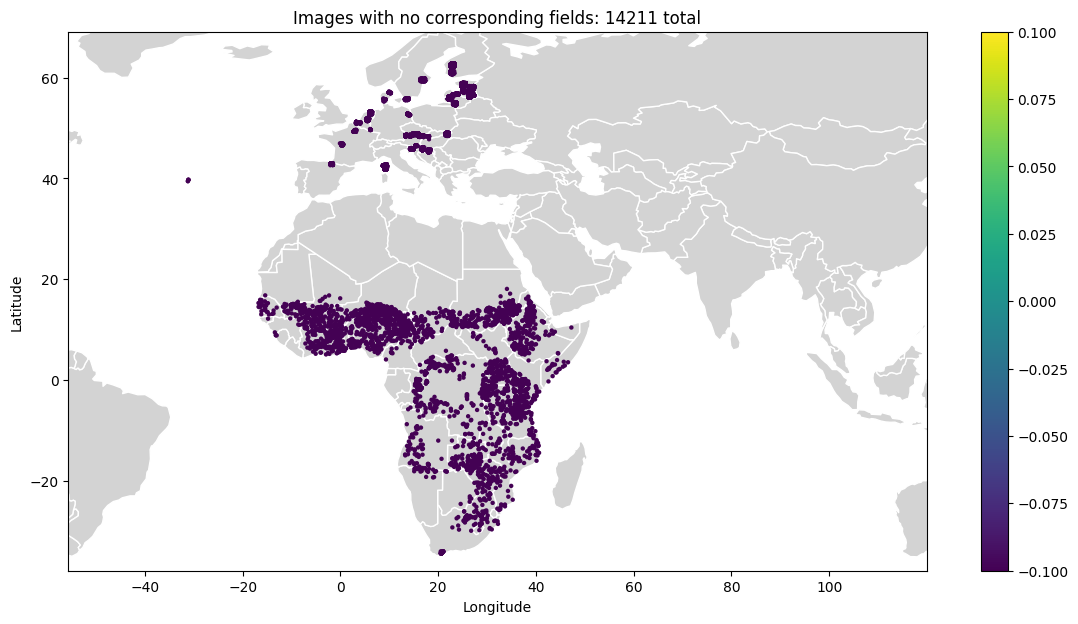

In [15]:
gdf_pts_subset = gdf_pts.query("nonfld_prop == 1")
# gdf_pts_subset = gdf_pts.query("dataset=='ftw' & nonfld_prop==1") 
# gdf_pts_subset = gdf_pts.query("dataset=='mappingafrica' & nonfld_prop==1") 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
world.plot(ax=ax, color="lightgray", edgecolor="white")
gdf_pts_subset.plot(column="fld_prop", cmap="viridis", legend=True, 
                    markersize=10, ax=ax, s=8, linewidths=0)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Images with no corresponding fields: " \
             f"{len(gdf_pts_subset)} total")
ax.set_xlim(gdf_pts.x.min() * 1.2, gdf_pts.x.max() * 1.1)
ax.set_ylim(gdf_pts.y.min() * 1.1, gdf_pts.y.max() * 1.1)
# cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
# cbar.set_label("field proportion")
plt.show()

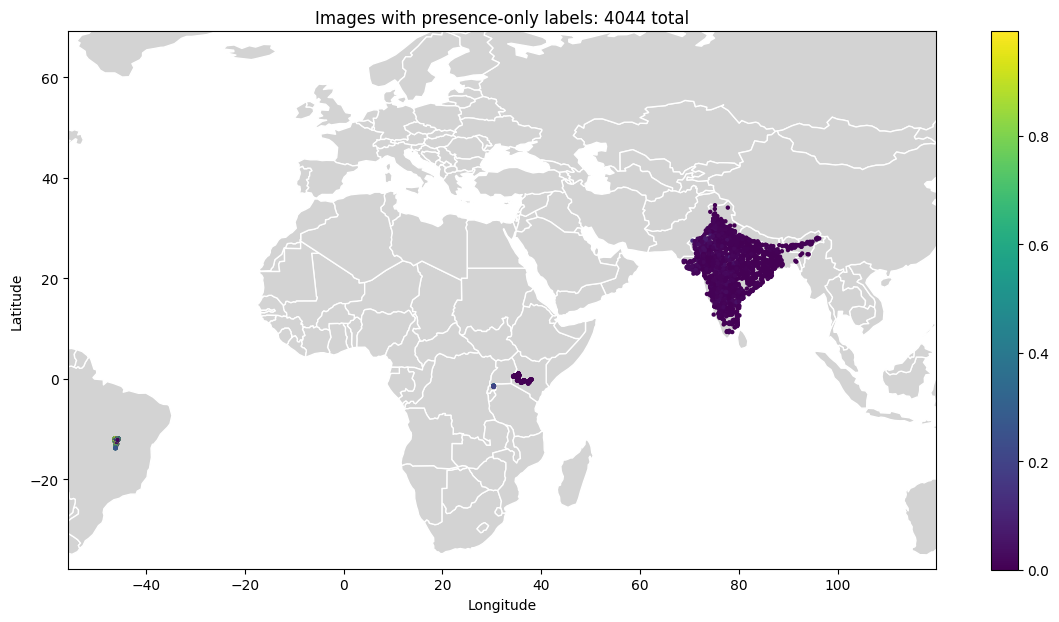

In [16]:
gdf_pts_subset = gdf_pts.query("null_prop > 0")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
world.plot(ax=ax, color="lightgray", edgecolor="white")
gdf_pts_subset.plot(column="fld_prop", cmap="viridis", legend=True, 
                    markersize=10, ax=ax, s=8, linewidths=0)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Images with presence-only labels: " \
             f"{len(gdf_pts_subset)} total")
ax.set_xlim(gdf_pts.x.min() * 1.2, gdf_pts.x.max() * 1.1)
ax.set_ylim(gdf_pts.y.min() * 1.1, gdf_pts.y.max() * 1.1)
# cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
# cbar.set_label("field proportion")
plt.show()

## Image statistics

Let's get global image statistics for each dataset.

In [3]:
ftw_cat = pd.read_csv(
    Path(project_dir) / "data/ftw-catalog.csv" 
)

In [4]:
# img.values.min(axis=(1,2)), img.values.max(axis=(1,2))
def image_stats(row):
    img = rxr.open_rasterio(Path(data_dir) / row["window_b"])
    nodata = getattr(img.rio, "nodata", None)
    if nodata is not None:
        img = img.where(img != nodata)

    valid_mask = ~np.isnan(img.values)
    valid_counts = valid_mask.sum(axis=(1,2))

    mus = img.values.mean(axis=(1,2))
    ssd = ((img.values - mus[:, None, None]) ** 2).sum(axis=(1,2))
    mins = img.values.min(axis=(1,2))
    maxs = img.values.max(axis=(1,2))

    stats_df = pd.DataFrame({
        "row": row["name"],
        "band": [f"band_{i+1}" for i in range(len(mins))],
        "min": mins,
        "max": maxs,
        "mean": mus,
        "ssd": ssd,
        "valid_count": valid_counts
    })
    return stats_df

img_stats = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(image_stats, row): idx 
               for idx, row in ftw_cat.iterrows()}
    for future in as_completed(futures):
        idx = futures[future]
        try:
            res = future.result()
            if res is not None:
                img_stats.append(res)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

img_stats_df = pd.concat(img_stats, ignore_index=True)

In [13]:
img_stats_df.groupby("band")["max"].quantile(0.99) 
img_stats_df.groupby("band")["min"].quantile(0.02)

band
band_1     2.0
band_2     9.0
band_3     0.0
band_4    42.0
Name: min, dtype: float64

In [ ]:
import xarray as xr
import dask.array as da
from glob import glob

def global_stats_dask(chip_paths, bands=None, percentiles=(2, 98)):
    """
    Compute global mean, std, and percentiles per band across chips using Dask.

    Parameters
    ----------
    chip_paths : list of str
        Paths to chip GeoTIFFs (same band structure).
    bands : list of int, optional
        Bands to process (1-based indices). If None, infer from first chip.
    percentiles : tuple
        Percentiles for robust min/max (default=(2, 98)).

    Returns
    -------
    dict
        Dictionary: band -> {mean, std, pXX, pYY}
    """

    # open all chips as a single lazy xarray Dataset
    datasets = [rxr.open_rasterio(p, chunks={"x": 1024, "y": 1024}) 
                for p in chip_paths]
    da_stack = xr.concat(datasets, dim="stacked_chip")

    # set bands if not provided
    if bands is None:
        bands = list(da_stack.band.values)

    stats = {}
    for b in bands:
        arr = da_stack.sel(band=b)

        # compute global mean & std (lazy)
        mean_val = arr.mean().compute().item()
        std_val = arr.std().compute().item()

        # compute global percentiles (lazy)
        # flatten to 1D dask array
        flat = arr.data.reshape(-1)
        pvals = da.percentile(flat, percentiles).compute()

        stats[int(b)] = {
            "mean": mean_val,
            "std": std_val,
            f"p{percentiles[0]}": pvals[0],
            f"p{percentiles[1]}": pvals[1],
        }

    return stats

In [18]:
chip_paths = [Path(data_dir) / p for p in ftw_cat["window_b"].to_list()]
stats = global_stats_dask(chip_paths, percentiles=(1, 2, 98, 99))

: 

In [ ]:
import math

n_list = [...]     # integers
mu_list = [...]    # floats
m2_list = [...]    # floats (sum of squared deviations per chunk)

N = sum(n_list)
mu = sum(nj * muj for nj, muj in zip(n_list, mu_list)) / N

M2 = 0.0
for nj, muj, m2j in zip(n_list, mu_list, m2_list):
    M2 += m2j + nj * (muj - mu)**2

# population std (use for normalization)
var_pop = M2 / N
std_pop = math.sqrt(var_pop)

# sample std (if you need unbiased estimator)
var_sample = M2 / (N - 1) if N > 1 else 0.0
std_sample = math.sqrt(var_sample)